In [40]:
import torch
import torch.nn as nn
from PIL import Image
import os
from IPython.display import display
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [41]:
class DenoiseDataset(Dataset):
    def __init__(self, images):
        self.images = images
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('L')  # Convert image to grayscale
        clean_image = self.noise_image(image)  # Add noise to image
        if self.transform:
            clean_image = self.transform(clean_image)
            image = self.transform(image)
        return clean_image, image
    
    @staticmethod
    def noise_image(image):
        # Normalize image
        image = image.resize((256, 256))
        image_array = np.array(image)
        image_array = image_array.astype(np.float32) / 255.0
        # Add noise
        mean = 0
        variance = 15 / 255  # Adjust noise level as needed
        noise = np.random.normal(mean, variance, image_array.shape)
        noisy_image_array = image_array + noise
        noisy_image = Image.fromarray((noisy_image_array * 255).astype(np.uint8))
        return noisy_image
    
   
class UNet_Denoise(nn.Module):

    def __init__(self):
        super(UNet_Denoise, self).__init__()

        # Convolution level 1
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # C2
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # C3
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # C4
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.conv5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)

        # Transposed convolution level 5
        self.transpose4 = nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv4_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.upconv4_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        # T3
        self.transpose3 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv3_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv3_1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        # T2
        self.transpose2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv2_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.Tconv2_1 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        # T1
        self.transpose1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv1_3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.upconv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.upconv1_1 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

        # Skip connections
        self.skip_connection1 = nn.Conv2d(64, 64, kernel_size=1)
        self.skip_connection2 = nn.Conv2d(128, 128, kernel_size=1)
        self.skip_connection3 = nn.Conv2d(256, 256, kernel_size=1)
        self.skip_connection4 = nn.Conv2d(512, 512, kernel_size=1)

    def forward(self, x):
        s1_1 = self.conv1_1(x)
        rel1 = F.relu(s1_1)
        s1_2 = self.conv1_2(rel1)
        rel2 = F.relu(s1_2)
        pooled1 = self.pool1(rel2)

        s2_1 = self.conv2_1(pooled1)
        rel3 = F.relu(s2_1)
        s2_2 = self.conv2_2(rel3)
        rel4 = F.relu(s2_2)
        pooled2 = self.pool2(rel4)

        s3_1 = self.conv3_1(pooled2)
        rel5 = F.relu(s3_1)
        s3_2 = self.conv3_2(rel5)
        rel6 = F.relu(s3_2)
        pooled3 = self.pool3(rel6)

        s4_1 = self.conv4_1(pooled3)
        rel7 = F.relu(s4_1)
        s4_2 = self.conv4_2(rel7)
        rel8 = F.relu(s4_2)
        pooled4 = self.pool4(rel8)

        # bottleneck
        s5_1 = self.conv5_1(pooled4)
        rel9 = F.relu(s5_1)
        s5_2 = self.conv5_2(rel9)
        rel10 = F.relu(s5_2)

        # after bottleneck
        up4 = self.transpose4(rel10)
        skip_con4 = self.skip_connection4(rel8)
        up4 = torch.cat([up4, skip_con4], dim=1)
        upconv4_2 = self.upconv4_2(up4)
        uprel4_2 = F.relu(upconv4_2)
        upconv4_1 = self.upconv4_1(uprel4_2)
        uprel4_1 = F.relu(upconv4_1)

        up3 = self.transpose3(uprel4_1)
        skip_con3 = self.skip_connection3(rel6)
        up3 = torch.cat([up3, skip_con3], dim=1)
        upconv3_2 = self.upconv3_2(up3)
        uprel3_2 = F.relu(upconv3_2)
        upconv3_1 = self.upconv3_1(uprel3_2)
        uprel3_1 = F.relu(upconv3_1)

        up2 = self.transpose2(uprel3_1)
        skip_con2 = self.skip_connection2(rel4)
        up2 = torch.cat([up2, skip_con2], dim=1)
        upconv2_2 = self.upconv2_2(up2)
        uprel2_2 = F.relu(upconv2_2)
        Tconv2_1 = self.Tconv2_1(uprel2_2)
        uprel2_1 = F.relu(Tconv2_1)

        up1 = self.transpose1(uprel2_1)
        skip_con1 = self.skip_connection1(rel2)
        up1 = torch.cat([up1, skip_con1], dim=1)
        upconv1_3 = self.upconv1_3(up1)
        uprel1_3 = F.relu(upconv1_3)
        upconv1_2 = self.upconv1_2(uprel1_3)
        uprel1_2 = F.relu(upconv1_2)
        upconv1_1 = self.upconv1_1(uprel1_2)
        output = F.relu(upconv1_1)
        return output

    def train(self,noisy_array,clean_array,loss_fn,optimizer,num_epochs=10):
        
        self.cuda()
        noisy_tensor = torch.tensor(noisy_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0).cuda()  # Add batch and channel dimensions
        clean_tensor = torch.tensor(clean_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0).cuda()

        for epoch in range(num_epochs):
            # Forward pass
            denoised_output = self.forward(noisy_tensor)
            
            # Compute the loss
            loss = loss_fn(denoised_output, clean_tensor)
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Display the denoised image
            denoised_array = denoised_output.squeeze().detach().cpu().numpy()  # Remove batch and channel dimensions, detach from computation graph, and move to CPU
            plt.imshow(denoised_array, cmap='Greys')  
            plt.axis('off')
            plt.title(f'Denoised Image (Epoch {epoch+1})')
            plt.show()
        
            # Print loss
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

    def predict(self,test_array,truth_array,loss_fn):
        self.cuda()
        test_tensor = torch.tensor(test_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0).cuda()
        truth_tensor = torch.tensor(truth_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0).cuda()
        denoised_tensor = self.forward(test_tensor)
        loss = loss_fn(denoised_tensor,truth_tensor)
        print("<<Predicted Image>>")
        denoised_array = denoised_tensor.squeeze().detach().cpu().numpy()
        plt.imshow(denoised_array, cmap='Greys')
        print("Loss: " + str(loss))
        
        
        


In [19]:
#initial training test
image_folder = "Train400"
input_image_path = os.path.join(image_folder, "test_001.png")
input_image = Image.open(input_image_path)

clean_array,noisy_array,clean_image,noisy_image = UNet_Denoise.noisyImage(input_image)

print("<<<Initial image>>")
display(clean_image)
print("<<<Noisy image>>")
display(noisy_image)

AttributeError: type object 'UNet_Denoise' has no attribute 'noisyImage'

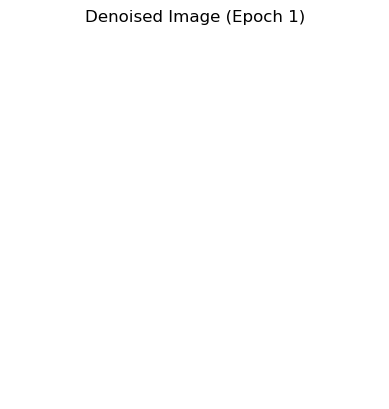

Epoch [1/50], Loss: 0.16629908978939056


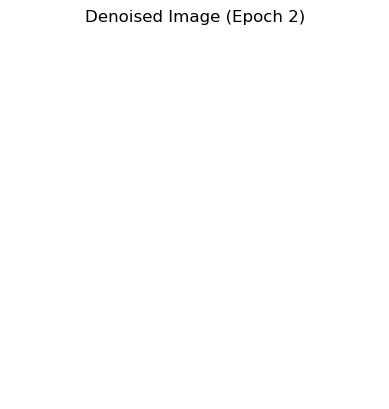

Epoch [2/50], Loss: 0.16629908978939056


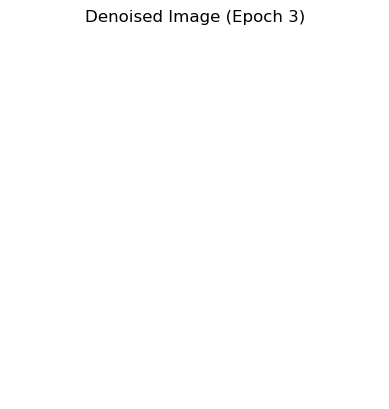

Epoch [3/50], Loss: 0.16629908978939056


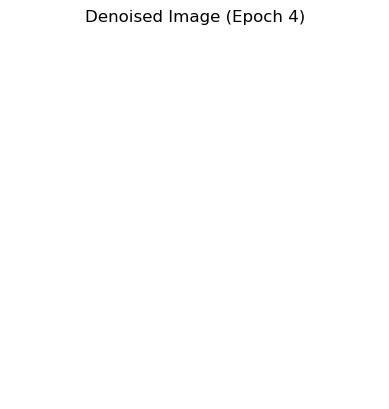

Epoch [4/50], Loss: 0.16629908978939056


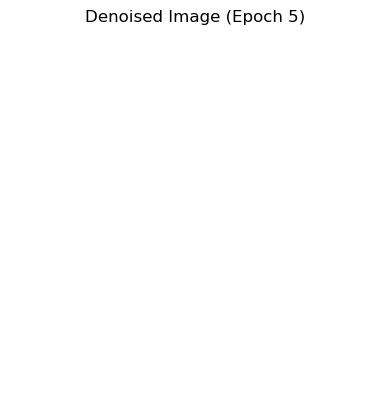

Epoch [5/50], Loss: 0.16629908978939056


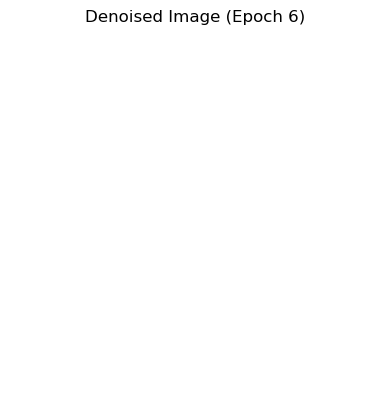

Epoch [6/50], Loss: 0.16629908978939056


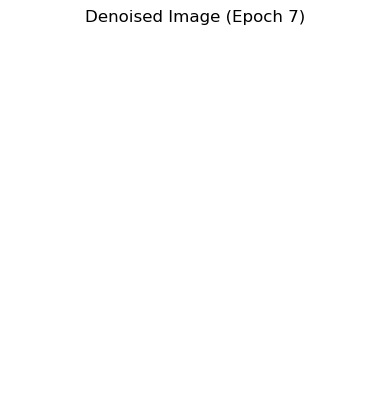

Epoch [7/50], Loss: 0.16629908978939056


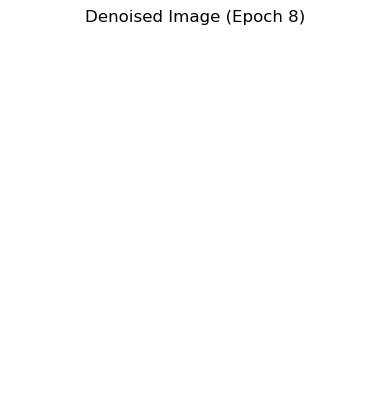

Epoch [8/50], Loss: 0.16629908978939056


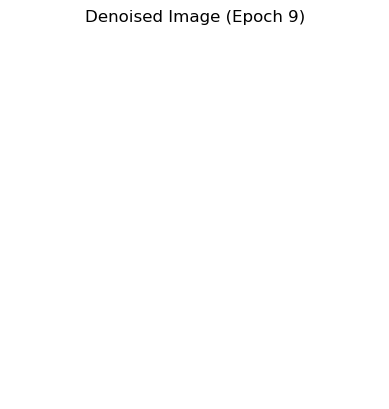

Epoch [9/50], Loss: 0.16629908978939056


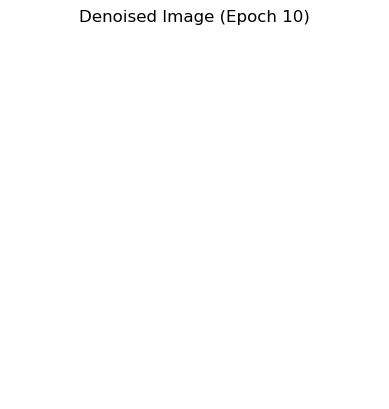

Epoch [10/50], Loss: 0.16629908978939056


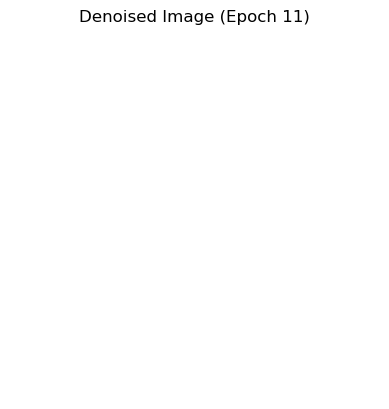

Epoch [11/50], Loss: 0.16629908978939056


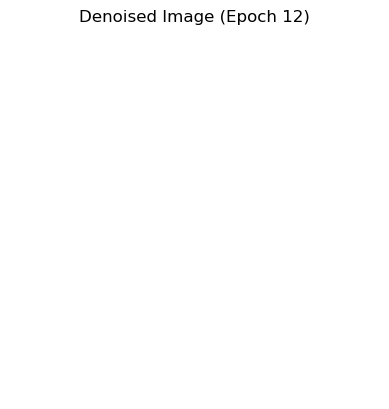

Epoch [12/50], Loss: 0.16629908978939056


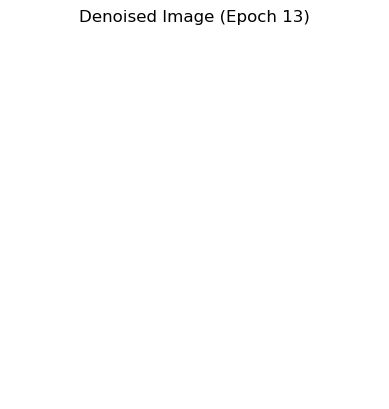

Epoch [13/50], Loss: 0.16629908978939056


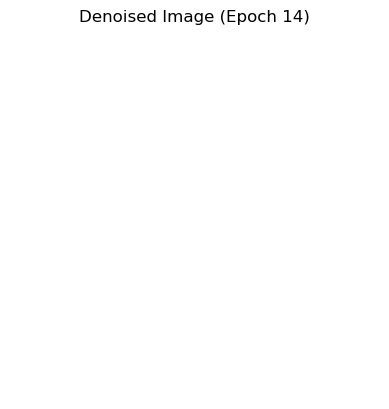

Epoch [14/50], Loss: 0.16629908978939056


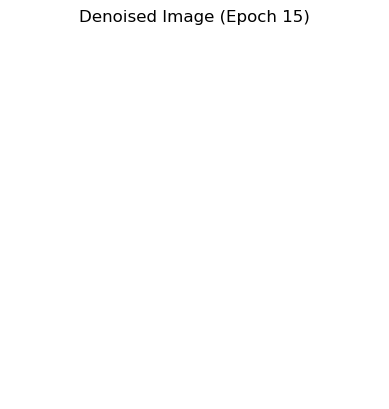

Epoch [15/50], Loss: 0.16629908978939056


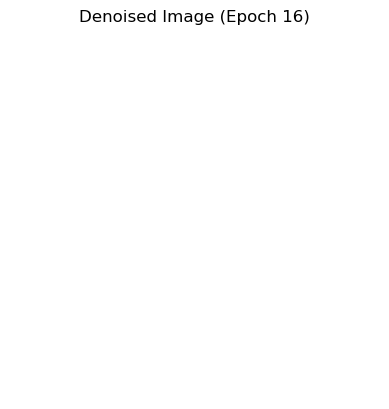

Epoch [16/50], Loss: 0.16629908978939056


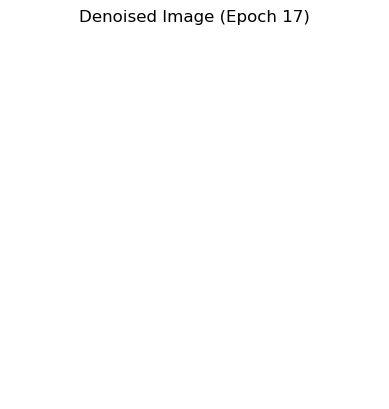

Epoch [17/50], Loss: 0.16629908978939056


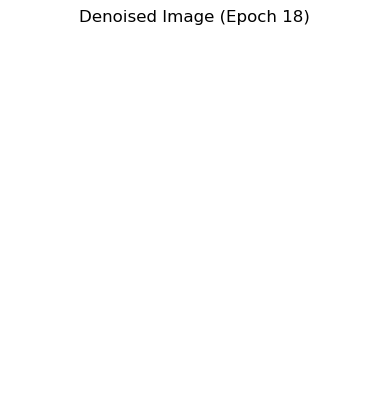

Epoch [18/50], Loss: 0.16629908978939056


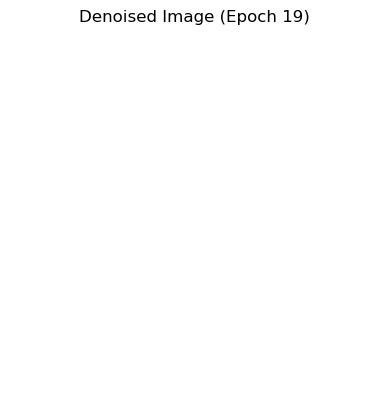

Epoch [19/50], Loss: 0.16629908978939056


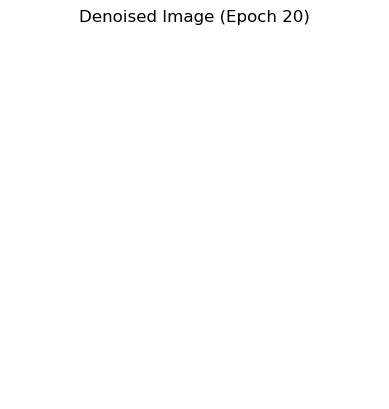

Epoch [20/50], Loss: 0.16629908978939056


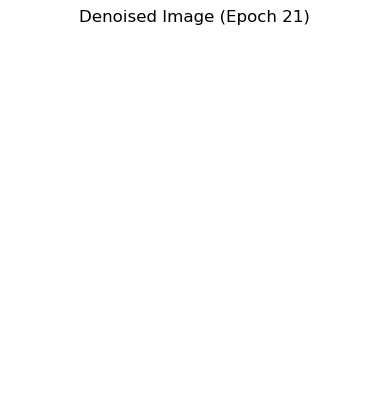

Epoch [21/50], Loss: 0.16629908978939056


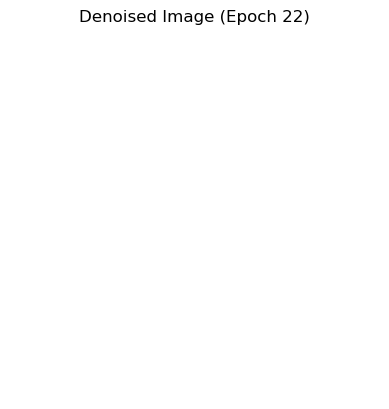

Epoch [22/50], Loss: 0.16629908978939056


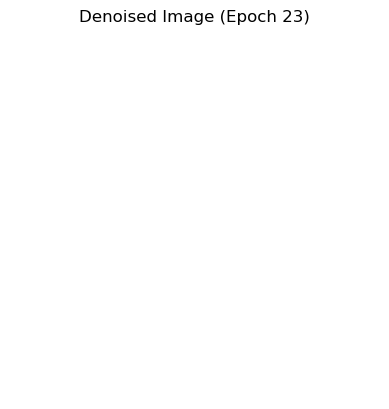

Epoch [23/50], Loss: 0.16629908978939056


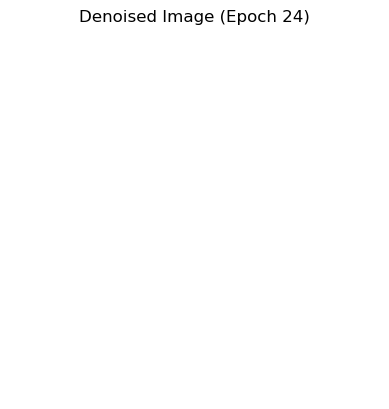

Epoch [24/50], Loss: 0.16629908978939056


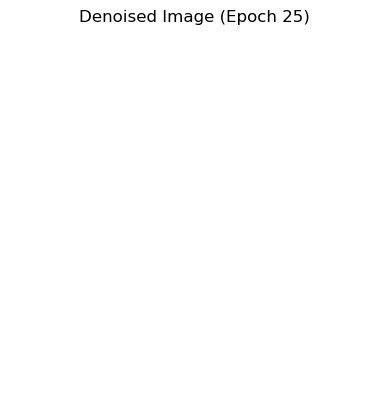

Epoch [25/50], Loss: 0.16629908978939056


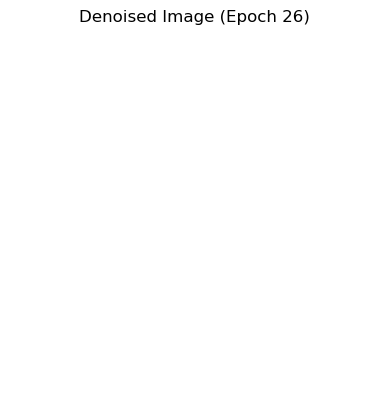

Epoch [26/50], Loss: 0.16629908978939056


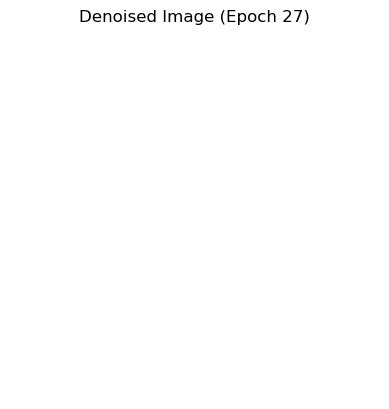

Epoch [27/50], Loss: 0.16629908978939056


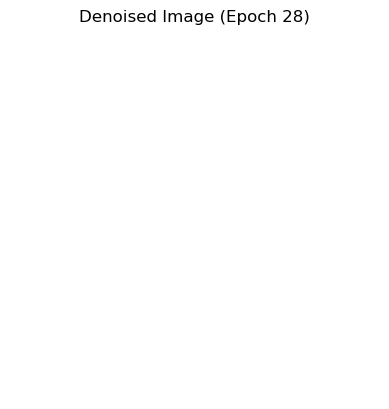

Epoch [28/50], Loss: 0.16629908978939056


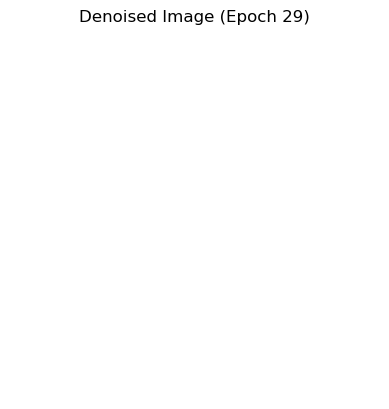

Epoch [29/50], Loss: 0.16629908978939056


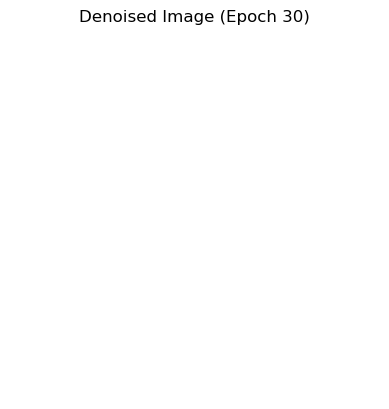

Epoch [30/50], Loss: 0.16629908978939056


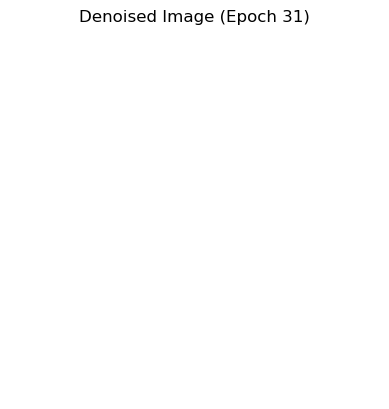

Epoch [31/50], Loss: 0.16629908978939056


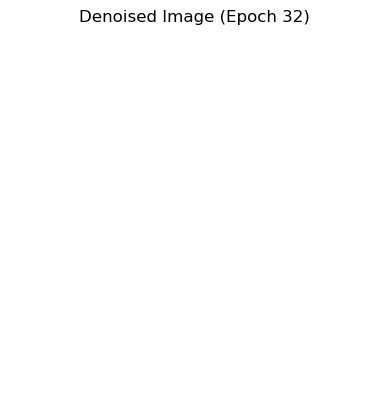

Epoch [32/50], Loss: 0.16629908978939056


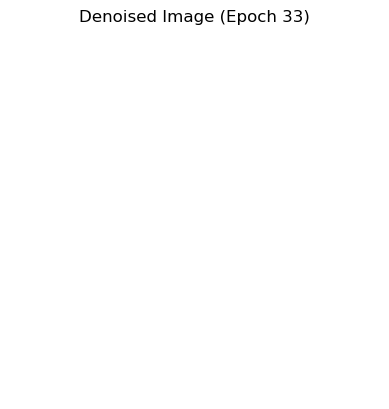

Epoch [33/50], Loss: 0.16629908978939056


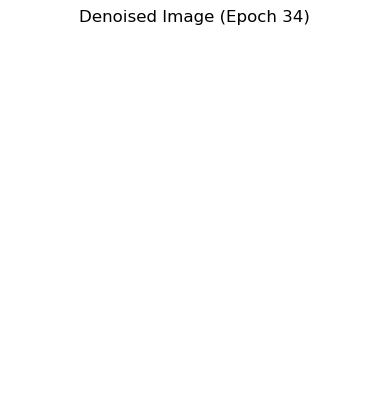

Epoch [34/50], Loss: 0.16629908978939056


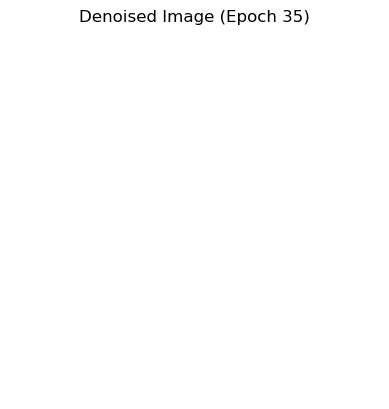

Epoch [35/50], Loss: 0.16629908978939056


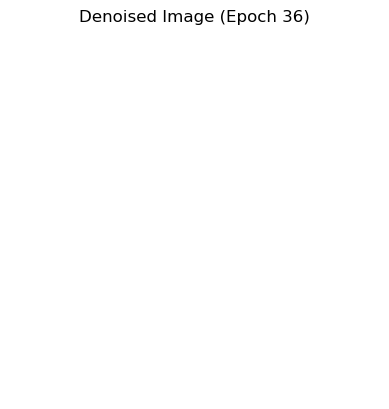

Epoch [36/50], Loss: 0.16629908978939056


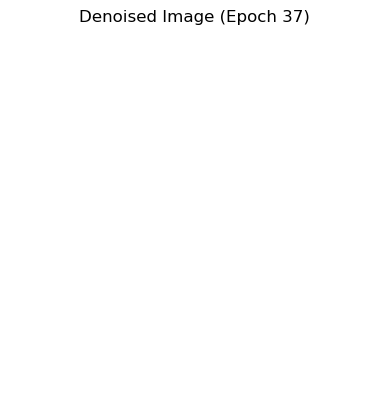

Epoch [37/50], Loss: 0.16629908978939056


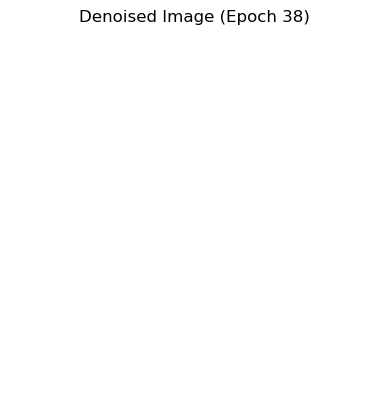

Epoch [38/50], Loss: 0.16629908978939056


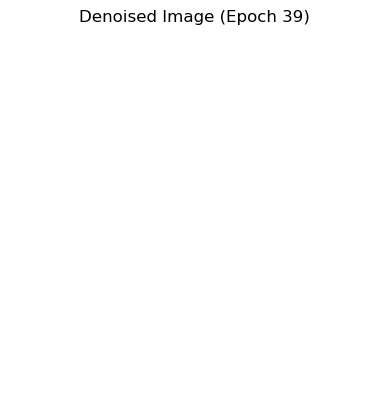

Epoch [39/50], Loss: 0.16629908978939056


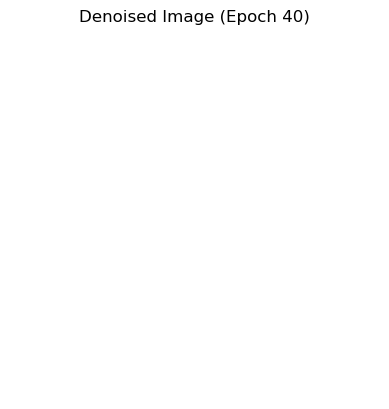

Epoch [40/50], Loss: 0.16629908978939056


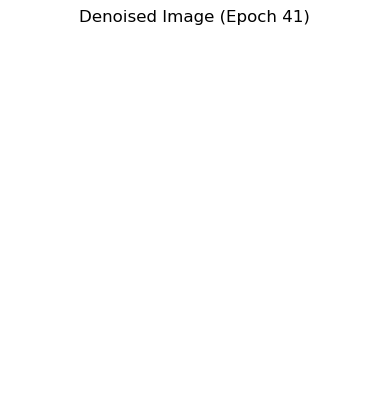

Epoch [41/50], Loss: 0.16629908978939056


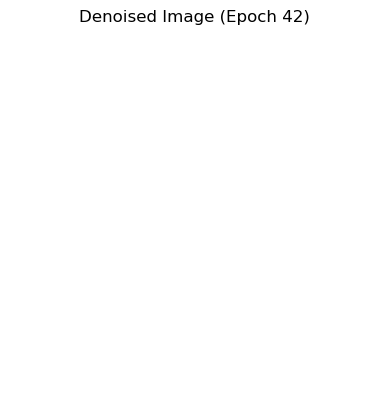

Epoch [42/50], Loss: 0.16629908978939056


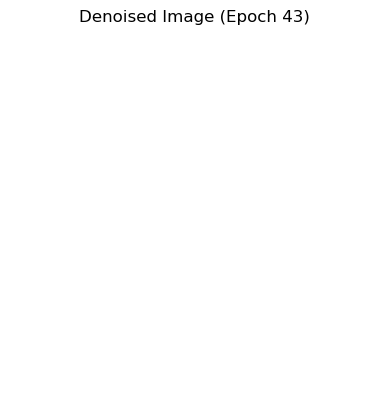

Epoch [43/50], Loss: 0.16629908978939056


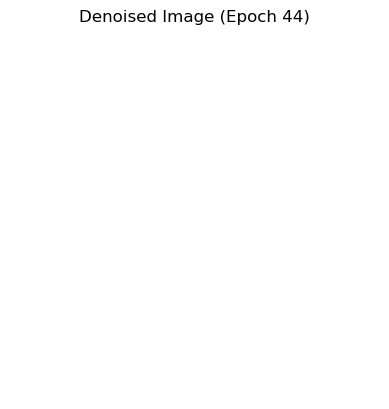

Epoch [44/50], Loss: 0.16629908978939056


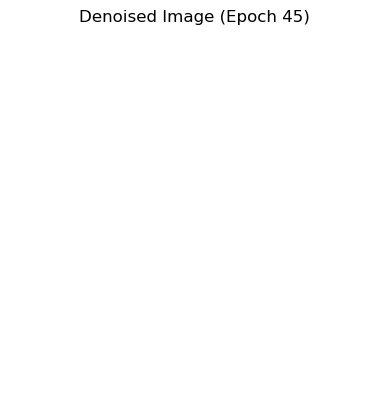

Epoch [45/50], Loss: 0.16629908978939056


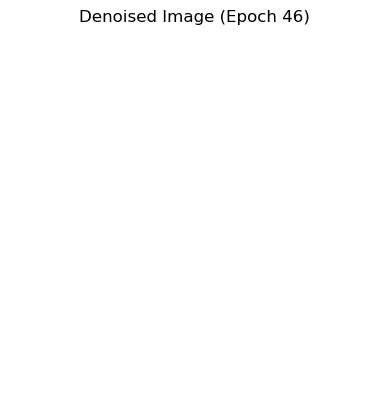

Epoch [46/50], Loss: 0.16629908978939056


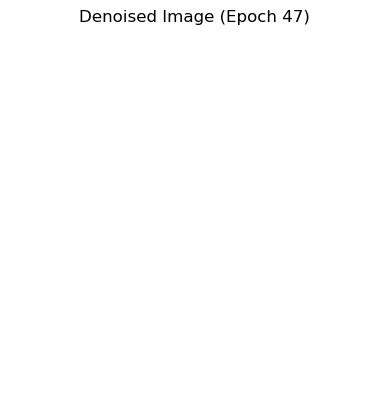

Epoch [47/50], Loss: 0.16629908978939056


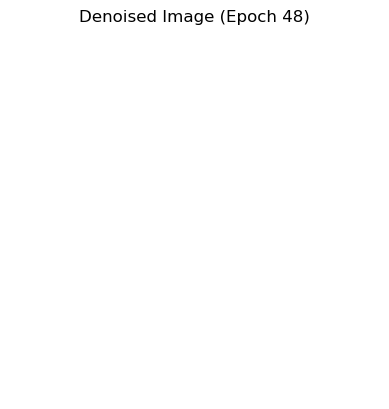

Epoch [48/50], Loss: 0.16629908978939056


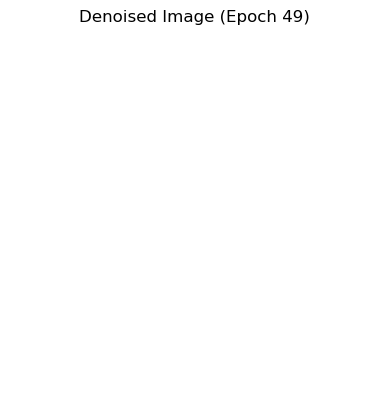

Epoch [49/50], Loss: 0.16629908978939056


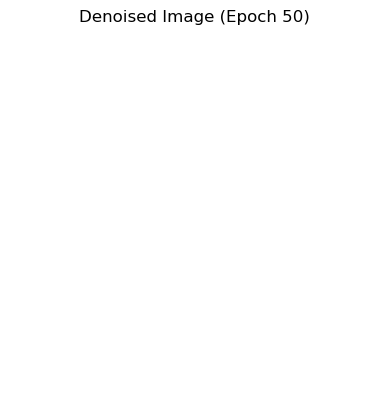

Epoch [50/50], Loss: 0.16629908978939056


In [13]:
model = UNet_Denoise()

loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # Adam optimizer
num_epochs = 50

model.train(noisy_array,clean_array,loss_fn,optimizer,num_epochs)


<<<Initial image>>


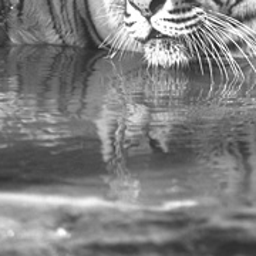

<<<Noisy image>>


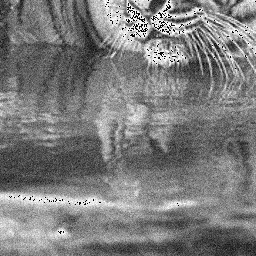

In [14]:
test_input_image_path = os.path.join(image_folder, "test_010.png")
test_input_image = Image.open(test_input_image_path)

clean_test_array,noisy_test_array,truth_image,test_image = UNet_Denoise.noisyImage(test_input_image)

print("<<<Initial image>>")
display(truth_image)
print("<<<Noisy image>>")
display(test_image)




<<Predicted Image>>
Loss: tensor(0.2750, device='cuda:0', grad_fn=<MseLossBackward0>)


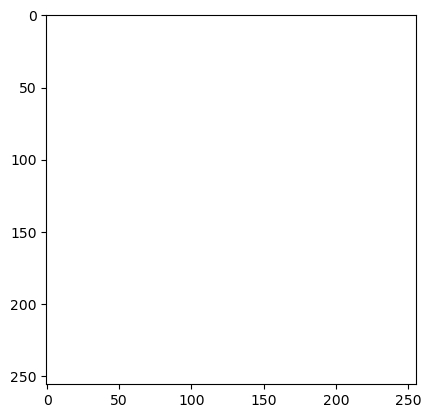

In [15]:
model.predict(noisy_test_array,clean_test_array,loss_fn)

In [ ]:
###########TESTING NEW IMPLEMENTATION

In [42]:
image_folder = "Train400"
image_path = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]

transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = DenoiseDataset(image_path, transform=transform)


batch_size = 10

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate your UNet model
model = UNet_Denoise()

# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch in data_loader:
        clean_images, noisy_images = batch
        clean_tensor = torch.stack([transforms.ToTensor()(img) for img in clean_images]).cuda()
        noisy_tensor = torch.stack([transforms.ToTensor()(img) for img in noisy_images]).cuda()

        # Forward pass
        denoised_output = model(noisy_tensor)

        # Compute the loss
        loss = loss_fn(denoised_output, clean_tensor)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')






TypeError: DenoiseDataset.__init__() got an unexpected keyword argument 'transform'